## Introduction
---

In this notebook the Vasicek model is calibrated using PCA on historical US treasury rates. This is based on the kaggle notebook https://www.kaggle.com/code/liamhealy/interest-rate-modelling-in-python (with corrections) and the following paper: *Calibration of the Vasicek Model: An Step by Step Guide by Victor Bernal A.*
   
Key skills:
- PCA analysis of US treasury yields
- Forecasting / Monte Carlo simulation
- Stocastic calculus

### Setup
---

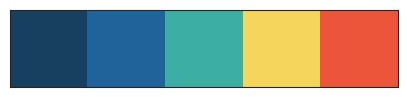

In [1]:
# Import packages
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import StandardScaler

from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from scipy.optimize import minimize

sns.set_style("white")

### Define the colour scheme
c1 = "#173f5f"
c2 = "#20639b"
c3 = "#3caea3"
c4 = "#f6d55c"
c5 = "#ed553b"

custom_palette = [c1, c2, c3, c4, c5]
sns.palplot(sns.color_palette(custom_palette))

# User defined function
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#total'] = df.shape[0]
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    summ['#duplicates'] = summ['#total'] - summ['#unique']
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    return summ

### Data Processing
---

In [2]:
# Import the data
df = pd.read_csv(r"C:\quant\rates\yield_curve_rates_1990_2023.csv")
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=False)

# Sort by Date
df = df.sort_values('Date')

# Date as index
df.set_index('Date', inplace=True)

# List the variables to keep (<25% missing) and rename
keep_vars = ['3 Mo','6 Mo','1 Yr','2 Yr','3 Yr','5 Yr','7 Yr','10 Yr','20 Yr']
rename_vars = ['3m','6m','12m','24m','36m','60m','84m','120m','240m']

# drop variable and rename
df = df[keep_vars]
df.columns = rename_vars

# Interpolate missing values linearly
df = df.interpolate()

# Drop rows with missing values still (when missing at beginning or end of time series)
df = df.dropna()

# View the data
summary(df).style.background_gradient(cmap='Blues')

,data type,#total,#missing,%missing,#unique,#duplicates,min,max
3m,float64,7568,0,0.000000,631,6937,0.000000,6.420000
6m,float64,7568,0,0.000000,637,6931,0.020000,6.670000
12m,float64,7568,0,0.000000,686,6882,0.040000,7.320000
24m,float64,7568,0,0.000000,729,6839,0.090000,7.740000
36m,float64,7568,0,0.000000,748,6820,0.100000,7.840000
60m,float64,7568,0,0.000000,742,6826,0.190000,7.900000
84m,float64,7568,0,0.000000,733,6835,0.360000,7.920000
120m,float64,7568,0,0.000000,726,6842,0.520000,8.050000
240m,float64,7568,0,0.000000,716,6852,0.870000,8.300000


### Visualising Data
---

In [3]:
def plot_rates(df):
    plot_vars = df.columns
    
    fig, ax = plt.subplots(figsize=(8,4), ncols=1, nrows=1)
    for var in plot_vars:
        ax.plot(df.index, df[var], label=var, lw=0.5)
    ax.set(title='Daily Interest Rate', xlabel='Date', ylabel='Interest Rate (%)')
    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
    plt.show()

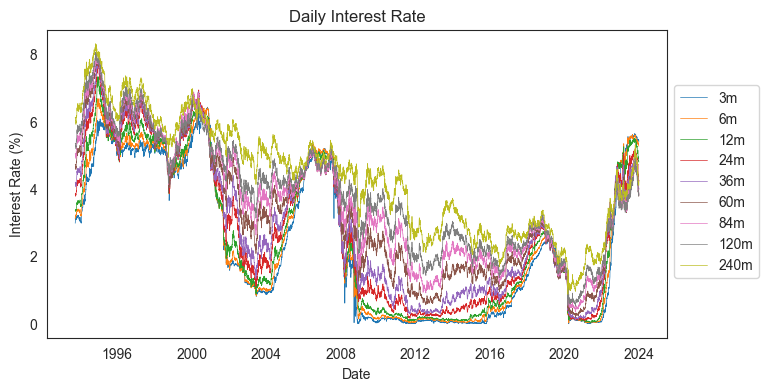

In [4]:
# Plot the daily interest rates
plot_rates(df)

### Principle Component Analysis (PCA)
---

The interest rates will not be decomoposed to key (principle) components. From these the key components are chosen such that they able to reconstruct and therefore explain the dataset.

The reconstruction will not be perfect but the aim is to have a trade off between the number of components and the reconstruction error.

Dimensionaility reduction error analysis:

- [Standardising the interest rate time series](#Standardising)
- [Computing the covariance matrix](#Covariance)
- [Eigenvalue and eigenvector decomposition](#Eigenvalue)
- [Selecting principle components](#principle)
- [Reconstructing the interest rates from the principle component scores](#reconstructing)


### Standardising the Data <a class="anchor" id="Standardising"></a>
Prepare the data for dimensionality reduction. Machine learning and optimization algorithms perform better when all the features are on the same scale. To achieve this the standardisation approach will be implemented. A feature value $x^{i}$ can be become a standardized feature value $x^{i}_s$ by using the following calculation:

$$x^{i}_{s} = \frac{x^{i} - \mu_x}{\sigma_x}$$


where $\mu_x$ is the mean of the feature column and $\sigma_{x}$  is the sample variance. Giving the feature values of mean 0 and a standard deviation 1, ie a standard Gaussian.

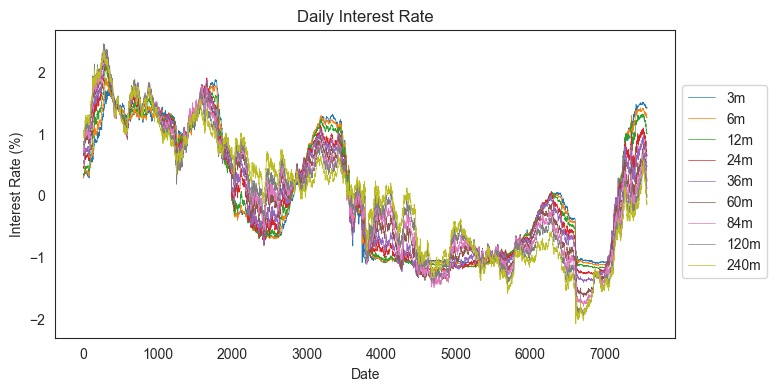

In [5]:
# Create instance of scalar
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(np.array(df)))
df_scaled.columns = df.columns

# Plot the scalared dataset
plot_rates(df_scaled)

### Covariance Matrix <a class="anchor" id="Covariance"></a>
Covariance measures how two features are linearily similar to each other. A positive covariance $\implies$ features move together in the same direction. However, a negative covariance $\implies$ that the two features move in opposite directions. For two feature vectors $x_{j}$ and $x_{k}$ the covariance between them $\sigma_{jk}$ can be calculated using the following equation:

$$\text{Cov}(x_{j}, x_{k}) = \mathbb{E}[(x_{j} - \mathbb{E}[x_{j}])(x_{k} - \mathbb{E}[x_{k}])]$$

Since the feature columns have been standardized, the covariance matrix $\Sigma$ can be calculated by the following:

$$\Sigma = \frac{1}{n-1} X^T X$$

where $X^{T}$ is the transpose of $X$. 

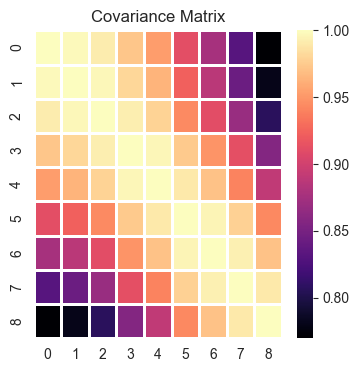

In [6]:
# Compute covariance matrix
X = np.array(df_scaled)
cov = (X.T @ X) / (X.shape[0] - 1)

# Display the covariance matix
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cov, cmap='magma',linecolor='white',linewidths=1, ax=ax)
ax.set(title="Covariance Matrix")
plt.show()

### Eigenvalue and Eigenvector Decomposition <a class="anchor" id="Eigenvalue"></a>
The eigenvectors represent the principal components (the directions of maximum variance) of the covariance matrix and the eigenvalues their corresponding magnitude. The eigenvector that has the largest corresponding eigenvalue represents the direction of maximum variance. An eigenvector $\mathbf{v}$ satisfies the following condition:

$$A \mathbf{v} = \lambda \mathbf{v}$$

Where $\lambda$ is the eigenvalue (scalar). 

In [7]:
# Eigenvalue and eigenvectors
eig_values, eig_vectors = np.linalg.eig(cov)

# View the eigenvalues and vectors
print("Eigenvalues:\t", eig_values[0])
print("Eigenvectors:\t", eig_vectors[0])

Eigenvalues:	 8.456495003136029
Eigenvectors:	 [-0.32758374  0.40724018  0.48264381 -0.4716862   0.32249675 -0.34419052
  0.09515365  0.19969556 -0.00275931]


### Selecting Principle Components <a class="anchor" id="principle"></a>
Eigenpairs have been computed and now need to be sorted based on the magnitude of their respective eigenvalues. We can then determine how many principal components to select for dimensionality reduction. This can be done by plotting the cumulative sum of the eigenvalues.

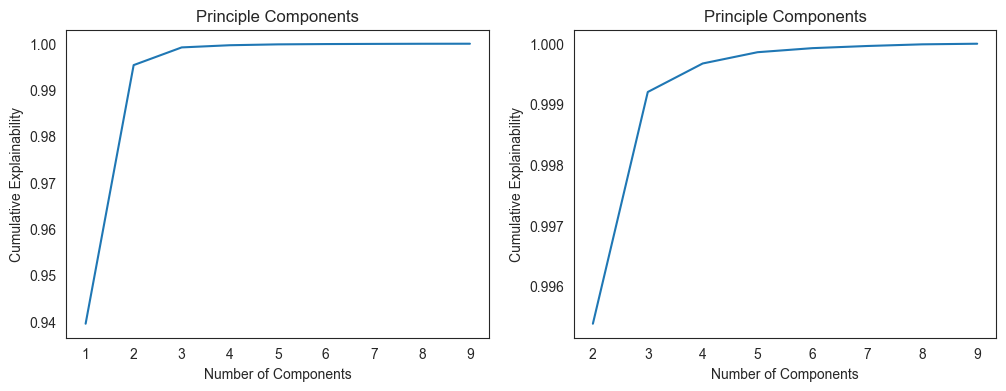

In [8]:
# Sort the eigenvectors
idx = np.argsort(eig_values, axis=0)[::-1]
sorted_eig_vectors = eig_vectors[:, idx]

# Cumulative sum of the eigenvalues
cumsum = np.cumsum(eig_values[idx]) / np.sum(eig_values[idx])
xint = range(1, len(cumsum) + 1)

# Plot the explainability by the number of components
fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
ax[0].plot(xint, cumsum)
ax[0].set(title='Principle Components', xlabel='Number of Components', ylabel='Cumulative Explainability')

ax[1].plot(xint[1:], cumsum[1:])
ax[1].set(title='Principle Components', xlabel='Number of Components', ylabel='Cumulative Explainability')
plt.show()

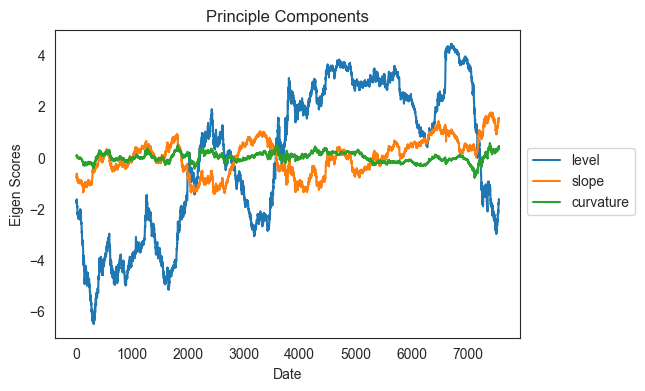

                 PC1       PC2       PC3
Date                                    
2023-12-15 -1.811850  1.521773  0.373891
2023-12-18 -1.847154  1.501532  0.385565
2023-12-19 -1.829184  1.495827  0.380411
2023-12-20 -1.740495  1.532601  0.409558
2023-12-21 -1.743567  1.499998  0.407527
2023-12-22 -1.744599  1.488412  0.424883
2023-12-26 -1.734779  1.488418  0.422985
2023-12-27 -1.625542  1.549128  0.437597
2023-12-28 -1.683893  1.532159  0.425598
2023-12-29 -1.690409  1.476683  0.433384


In [9]:
pc_scores = np.dot(X, sorted_eig_vectors[:, :3])

fig, ax = plt.subplots(figsize=(6,4), ncols=1, nrows=1)
for i, pca in enumerate(['level','slope','curvature']):
    ax.plot(pc_scores[:,i], label=pca)
ax.set(title='Principle Components', xlabel='Date', ylabel='Eigen Scores')
fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.show()

df_pca = pd.DataFrame(pc_scores, columns=['PC1','PC2','PC3'])
df_pca.index = df.index

print(df_pca.tail(10))

### Interest Rate Recomposition <a class="anchor" id="reconstructing"></a>

To reconstruct the original variables from a principal component ($PC$), we can map it back to the original space using the transpose of the matrix of eigenvectors ($V^T$). The reconstruction is obtained by multiplying the PC scores ($Z$) with the transpose of the eigenvectors matrix ($V^T$):

$$\hat{X} = ZV^T$$

To obtain the final reconstruction ($\hat{X}_{raw}$) we need to add the mean vector ($\mu$) to the result:

$$ \text{PCA reconstruction} = Z\cdot V^T + \mu$$

It's worth noting that directly going from the original space to the reconstructed space can be achieved by multiplying the original data matrix ($X$) with the product of eigenvectors and their transpose ($VV^T$). This multiplication is referred to as a projection matrix. If all eigenvectors are used, $VV^T$ is the identity matrix, resulting in perfect reconstruction. However, if a subset of eigenvectors are used, we introduce dimensionality reduction.

For any point ($z$) in the principal component space, you can map it back to the original space using the formula $\hat{X}=zV^T$. This process allows for the reconstruction of the original variables from their principal components.

Principle Component Score Array Shape:	 (7568, 3)


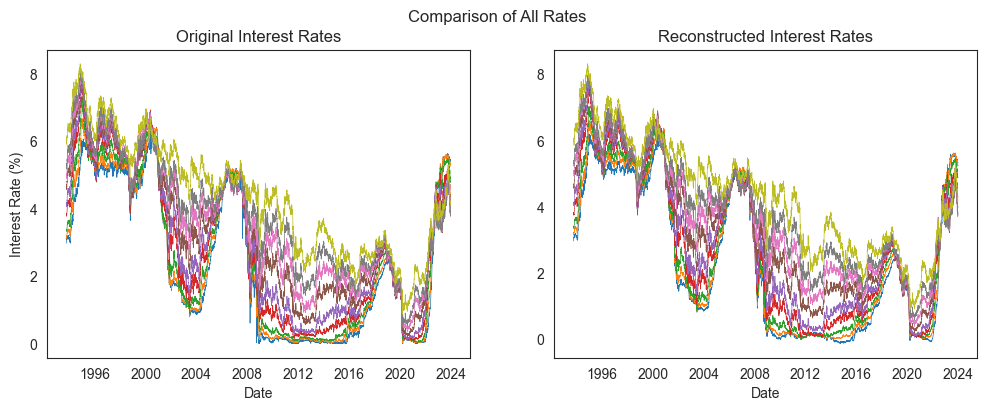

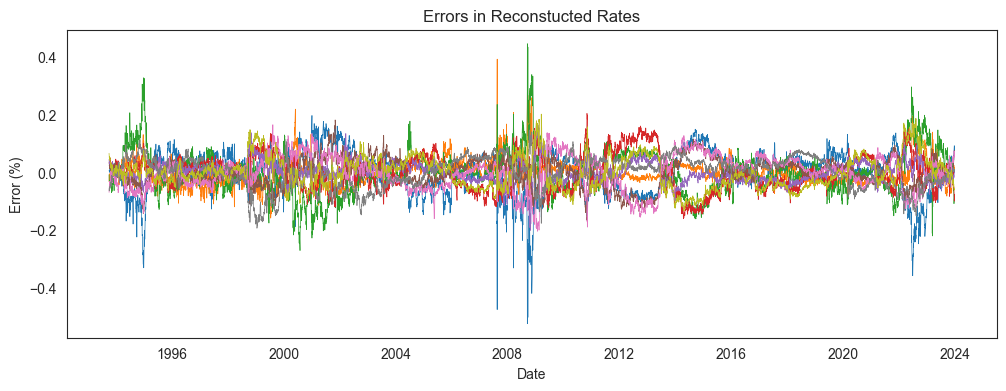

In [10]:
# Reconstruct the standardised interest rates
reconstructed_scaled_rates = np.dot(pc_scores, sorted_eig_vectors[:, :3].T)

# Remove standardisation
reconstructed_rates = scaler.inverse_transform(reconstructed_scaled_rates)

print("Principle Component Score Array Shape:\t", pc_scores.shape)

# Plotting before and after PCA
plot_vars = df.columns
fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
plt.suptitle('Comparison of All Rates')
ax[0].plot(df.index, df[plot_vars], lw=0.5)
ax[0].set(title='Original Interest Rates', xlabel='Date', ylabel='Interest Rate (%)')

ax[1].plot(df.index, reconstructed_rates, lw=0.5)
ax[1].set(title='Reconstructed Interest Rates', xlabel='Date')
plt.show()

# Assessing accuracy of recomposition
errors = np.array(df[plot_vars]) - reconstructed_rates

fig, ax = plt.subplots(figsize=(12,4), ncols=1, nrows=1)
ax.plot(df.index, errors, lw=0.5)
ax.set(title='Errors in Reconstucted Rates', xlabel='Date', ylabel='Error (%)')
plt.show()

### Simulation
---

### Overview

Next the application of the Vasicek short-rate model as a forecasting tool for each of the principal components over the next 12 months. This involves leveraging a stochastic model that incorporates mean reversion to simulate interest rate dynamics. The calibration process, facilitated by Maximum Likelihood Estimation (MLE) (and later by the quantile method), allows us to determine key parameters such as mean reversion strength ($\kappa$), long-run mean ($\theta$), and volatility ($\sigma$). 

Monte Carlo simulations based on the Vasicek model will be used to project interest rate paths, providing potential future paths of the PCs.

### Vasicek Model

The Vasicek model, named after economist Oldřich Vašíček, is a stochastic model widely employed in finance to describe the evolution of interest rates over time. Introduced in 1977, the model assumes that interest rates exhibit mean reversion, meaning they tend to move towards a long-term average or equilibrium level. 

\begin{equation}
dr(t) = \kappa (\theta - r(t))\,dt + \sigma\,dW(t)
\end{equation}

where:
- $r(t)$ is the short-term interest rate at time
- $\kappa$ is the mean reversion strength    (lambda)
- $\theta$ is the long-run mean or the equilibrium interest rate   (mu)
- $\sigma$ is the volatility
- $dW(t)$ is a Wiener process (Brownian motion)



In [11]:
def VasicekCalibration(rates, dt=1/252):
    '''
    MLE Calibration function
    '''
    n = len(rates)
    
    Sx = sum(rates.iloc[0:(n-1)])
    Sy = sum(rates.iloc[1:n])
    Sxx = np.dot(rates.iloc[0:(n-1)], rates.iloc[0:(n-1)])
    Sxy = np.dot(rates.iloc[0:(n-1)], rates.iloc[1:n])
    Syy = np.dot(rates.iloc[1:n], rates.iloc[1:n])
    
    theta = (Sy * Sxx - Sx * Sxy) / (n * (Sxx - Sxy) - (Sx**2 - Sx*Sy))
    kappa = -np.log((Sxy - theta * Sx - theta * Sy + n * theta**2) / (Sxx - 2*theta*Sx + n*theta**2)) / dt
    a = np.exp(-kappa * dt)
    sigmah2 = (Syy - 2*a*Sxy + a**2 * Sxx - 2*theta*(1-a)*(Sy - a*Sx) + n*theta**2 * (1-a)**2) / n
    sigma = np.sqrt(sigmah2*2*kappa / (1-a**2))
    r0 = rates.iloc[n-1]
    
    return [kappa, theta, sigma, r0]

def VasicekNextRate(r, kappa, theta, sigma, dt=1/252):  
    '''
    Simulate next rate
    '''
    val1 = np.exp(-1*kappa*dt)
    val2 = (sigma**2)*(1-val1**2) / (2*kappa)
    out = r*val1 + theta*(1-val1) + (np.sqrt(val2))*np.random.normal()
    return out

def VasicekSim(N, r0, kappa, theta, sigma, dt = 1/252):
    '''
    Simulate single rate path
    '''
    short_r = [0]*N   
    short_r[0] = r0     
    
    for i in range(1,N):
        short_r[i] = VasicekNextRate(short_r[i-1], kappa, theta, sigma, dt)
    
    return short_r

def VasicekMultiSim(M, N, r0, kappa, theta, sigma, dt = 1/252):
    '''
    Simulate multiple rate paths
    '''
    sim_arr = np.ndarray((N, M))
    
    for i in range(0,M):
        sim_arr[:, i] = VasicekSim(N, r0, kappa, theta, sigma, dt)
    
    return sim_arr

In [12]:
#implement Long Term Quantile Method calibration 

def quantile_VasicekCalibration(rates, dt=1/252, sigma= 0.2):
    """Long Term Quantile based calibration"""
    
    upper_quantile = rates.quantile(0.95)

    lower_quantile = rates.quantile(0.05)

    theta = 0.5* (upper_quantile+lower_quantile)

    kappa = (2*(sigma*1.96)**2) / (upper_quantile -lower_quantile)**2

    return kappa, theta

def quantile_VasicekNextRate(r, kappa, theta, sigma =0.02, dt=1/252):  
    '''
    Simulate next rate
    '''
    val1 = kappa * (theta - r)*dt
    val2 = (sigma)*np.sqrt(dt)
    out = r + val1 + val2*np.random.normal()
    return out


def quantile_VasicekSim(N, r0, kappa, theta, sigma = 0.2, dt = 1/252):
    """Simulate single rate path"""

    short_r = [0]*N   
    short_r[0] = r0     
    
    for i in range(1,N):
        short_r[i] = quantile_VasicekNextRate(short_r[i-1], kappa, theta, sigma, dt)
    
    return short_r

def quantile_VasicekMultiSim(M, N, r0, kappa, theta, sigma=0.2, dt = 1/252):
    '''
    Simulate multiple rate paths
    '''
    sim_arr = np.ndarray((N, M))
    
    for i in range(0,M):
        sim_arr[:, i] = quantile_VasicekSim(N, r0, kappa, theta, sigma, dt)
    
    return sim_arr

### Calibrate Each Principle Component
The calibrated principle components are being stored in the dataframe `df_params` so that they can easily be retrieved in the following simulation steps.

In [13]:
loop = 0
for pc in ['PC1','PC2','PC3']:
    params = VasicekCalibration(df_pca[pc].dropna())
    
    if loop==0:
        df_params = pd.DataFrame({'PC':[pc], 'kappa':[params[0]], 'theta':[params[1]], 'sigma': [params[2]]})
        loop += 1
    else:
        tmp = pd.DataFrame({'PC':[pc], 'kappa':[params[0]], 'theta':[params[1]], 'sigma': [params[2]]})
        df_params = pd.concat([df_params, tmp], axis=0)
        loop += 1

df_params = df_params.set_index('PC')
df_params

,kappa,theta,sigma
PC,,,
PC1,0.075914,0.028335,1.129757
PC2,0.282409,0.267529,0.579402
PC3,1.458571,0.008797,0.326452


In [14]:
loop = 0
for pc in ['PC1','PC2','PC3']:
    quantile_params = quantile_VasicekCalibration(df_pca[pc].dropna())
    
    if loop==0:
        df_params_quantile = pd.DataFrame({'PC':[pc], 'kappa':[quantile_params[0]], 'theta':[quantile_params[1]]})
        loop += 1
    else:
        tmp = pd.DataFrame({'PC':[pc], 'kappa':[quantile_params[0]], 'theta':[quantile_params[1]]})
        df_params_quantile = pd.concat([df_params_quantile, tmp], axis=0)
        loop += 1

df_params_quantile = df_params_quantile.set_index('PC')
df_params_quantile

,kappa,theta
PC,,
PC1,0.004366,-0.484662
PC2,0.059661,-0.036825
PC3,0.940969,-0.001951


### Simulate Principle Component
The principle components are simulated using the calibrated parameters from the previous step and setting the number of simulation $M$.

In [15]:
years = 1
N = years * 252
t = np.arange(0,N)/252
r0 = 0
M = 1000

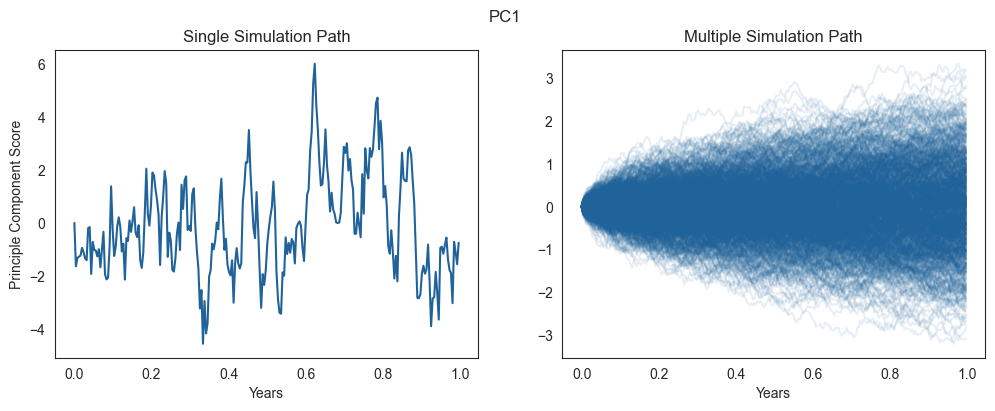

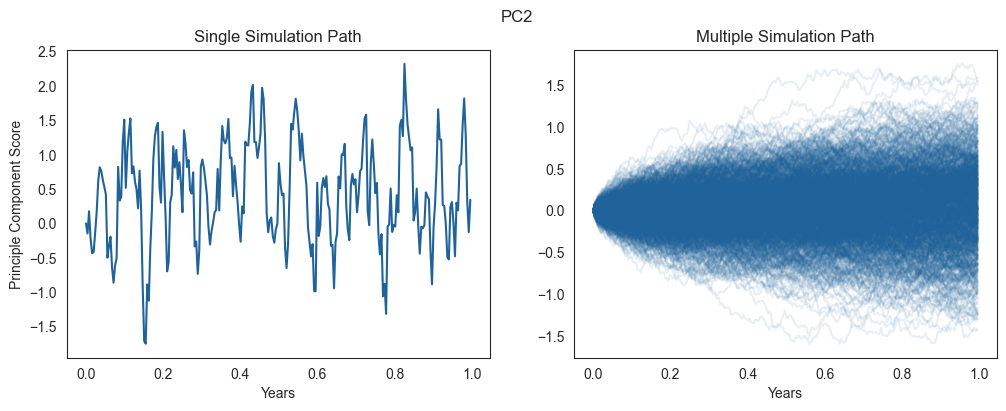

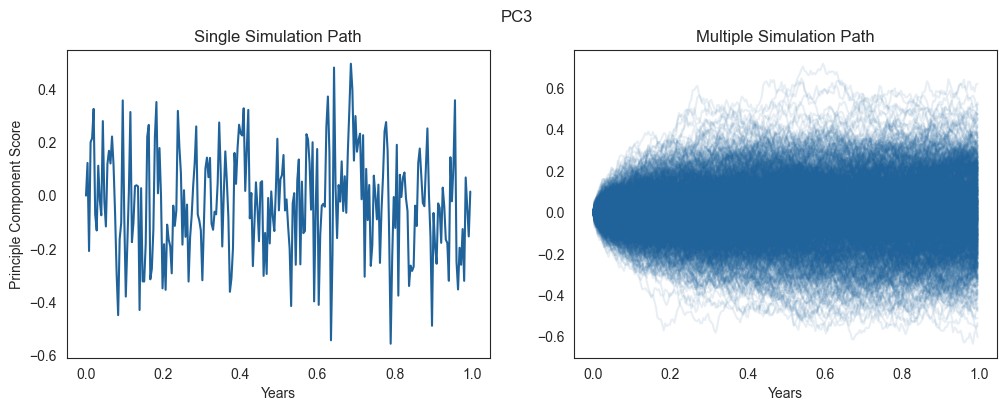

In [16]:
# MLE approach

for pc in ['PC1','PC2','PC3']:
    test_sim = VasicekSim(N, r0, df_params.loc[pc, 'kappa'], df_params.loc[pc, 'theta'], df_params.loc[pc, 'sigma'], 1)
    rates_arr = VasicekMultiSim(M, N, r0, df_params.loc[pc, 'kappa'], df_params.loc[pc, 'theta'], df_params.loc[pc, 'sigma'])
    
    fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
    plt.suptitle(pc)
    ax[0].plot(t,test_sim, color=c2)
    ax[0].set(title='Single Simulation Path', xlabel='Years', ylabel='Principle Component Score')
    ax[1].plot(t,rates_arr, color=c2, alpha=0.1)
    ax[1].set(title='Multiple Simulation Path', xlabel='Years')
    plt.show()

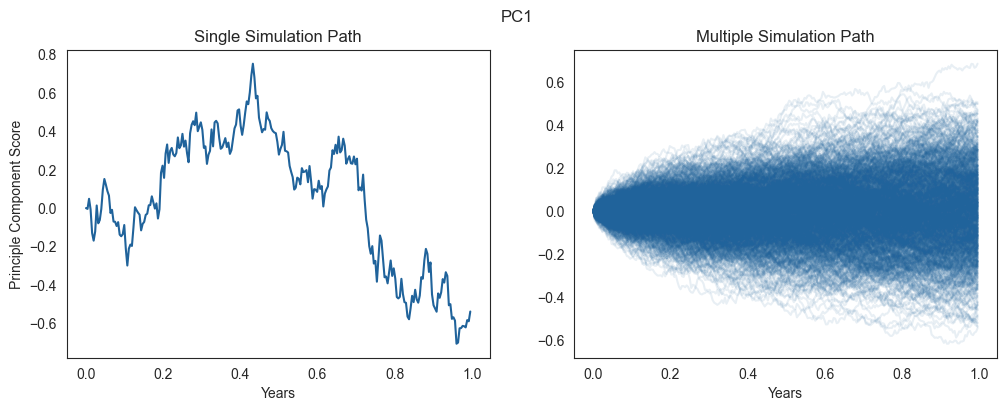

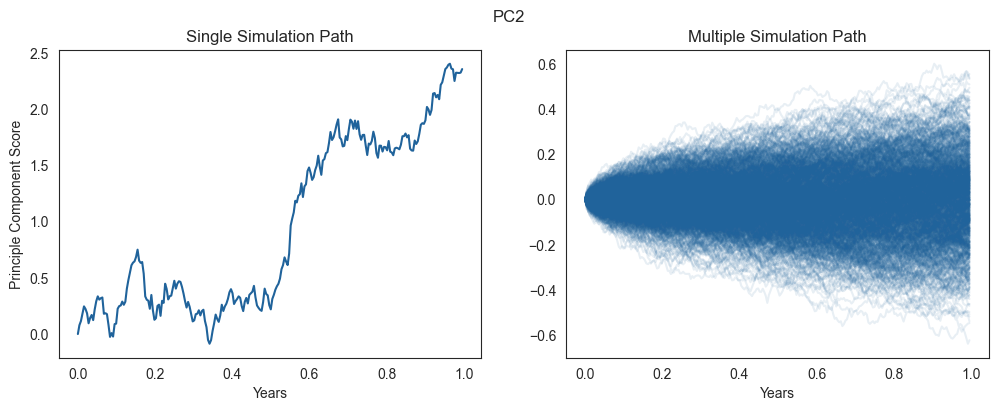

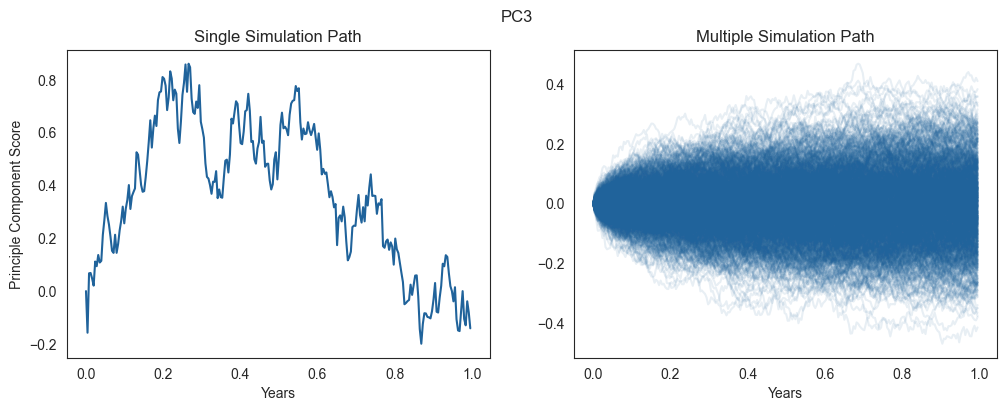

In [17]:
# Quantile approach

for pc in ['PC1','PC2','PC3']:
    test_sim_quan = quantile_VasicekSim(N, r0, df_params_quantile.loc[pc, 'kappa'], df_params_quantile.loc[pc, 'theta'], 1)
    rates_arr_quan = quantile_VasicekMultiSim(M, N, r0, df_params_quantile.loc[pc, 'kappa'], df_params_quantile.loc[pc, 'theta'])
    
    fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
    plt.suptitle(pc)
    ax[0].plot(t,test_sim_quan, color=c2)
    ax[0].set(title='Single Simulation Path', xlabel='Years', ylabel='Principle Component Score')
    ax[1].plot(t,rates_arr_quan, color=c2, alpha=0.1)
    ax[1].set(title='Multiple Simulation Path', xlabel='Years')
    plt.show()

### Reconstruct Simulted Interest Rates
The final step in this process is to simulate each of the principle components and reconstruct the interest rates to get the projections for each of the interest rate paths.

In [18]:
sim_pc1_arr = VasicekMultiSim(M, N, r0, 
                              df_params.loc['PC1', 'kappa'], 
                              df_params.loc['PC1', 'theta'], 
                              df_params.loc['PC1', 'sigma'])

sim_pc2_arr = VasicekMultiSim(M, N, r0, 
                              df_params.loc['PC2', 'kappa'], 
                              df_params.loc['PC2', 'theta'], 
                              df_params.loc['PC2', 'sigma'])

sim_pc3_arr = VasicekMultiSim(M, N, r0, 
                              df_params.loc['PC3', 'kappa'], 
                              df_params.loc['PC3', 'theta'], 
                              df_params.loc['PC3', 'sigma'])

sim_stack_arr = np.stack((sim_pc1_arr, sim_pc2_arr, sim_pc3_arr), axis=1)
print("Shape of PC simulation array:\t", sim_stack_arr.shape)

Shape of PC simulation array:	 (252, 3, 1000)


Shape of Interest Rate simulation array:	 (252, 9, 1000)


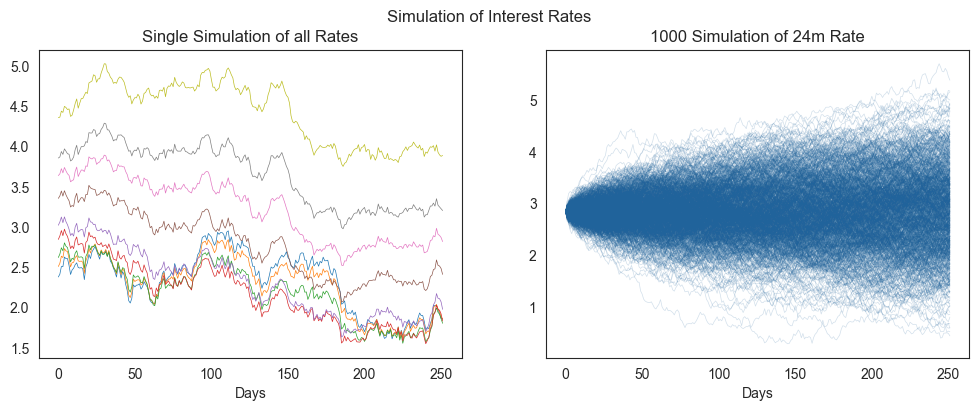

In [19]:
# Reconstruct the interest rates from the simulated principle components
for i in range(M):
    reconstructed_scaled_rates = np.dot(sim_stack_arr[:,:,i], sorted_eig_vectors[:, :3].T)
    reconstructed_rates = scaler.inverse_transform(reconstructed_scaled_rates)

    if i == 0:
        rates_sims = reconstructed_rates 
    else:
        rates_sims = np.dstack((rates_sims, reconstructed_rates))

print("Shape of Interest Rate simulation array:\t", rates_sims.shape)

# Plotting the simulated interest rates
plot_vars = df.columns
fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
plt.suptitle('Simulation of Interest Rates')

ax[0].plot(reconstructed_rates, lw=0.5)
ax[0].set(title='Single Simulation of all Rates', xlabel='Days')

ax[1].plot(rates_sims[:,3,:], color=c2, alpha=0.2, lw=0.5)
ax[1].set(title='1000 Simulation of {} Rate'.format(plot_vars[3]), xlabel='Days')
plt.show()

Shape of PC simulation array:	 (252, 3, 1000)
Shape of Interest Rate simulation array:	 (252, 9, 1000)


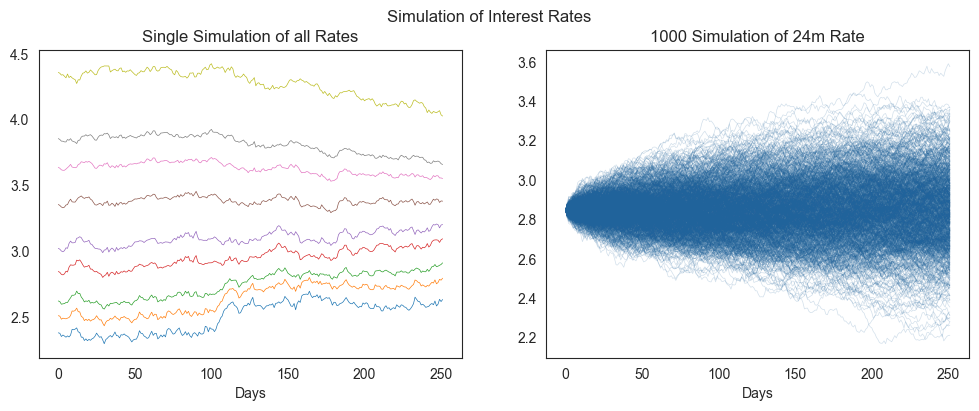

In [20]:
quantile_sim_pc1_arr = quantile_VasicekMultiSim(M, N, r0, 
                              df_params_quantile.loc['PC1', 'kappa'], 
                              df_params_quantile.loc['PC1', 'theta'])

quantile_sim_pc2_arr = quantile_VasicekMultiSim(M, N, r0, 
                              df_params_quantile.loc['PC2', 'kappa'], 
                              df_params_quantile.loc['PC2', 'theta'])

quantile_sim_pc3_arr = quantile_VasicekMultiSim(M, N, r0, 
                              df_params_quantile.loc['PC3', 'kappa'], 
                              df_params_quantile.loc['PC3', 'theta'])

quantile_sim_stack_arr = np.stack((quantile_sim_pc1_arr, quantile_sim_pc2_arr, quantile_sim_pc3_arr), axis=1)
print("Shape of PC simulation array:\t", quantile_sim_stack_arr.shape)


# Reconstruct the interest rates from the simulated principle components
for i in range(M):
    quantile_reconstructed_scaled_rates = np.dot(quantile_sim_stack_arr[:,:,i], sorted_eig_vectors[:, :3].T)
    quantile_reconstructed_rates = scaler.inverse_transform(quantile_reconstructed_scaled_rates)

    if i == 0:
        quantile_rates_sims = quantile_reconstructed_rates 
    else:
        quantile_rates_sims = np.dstack((quantile_rates_sims, quantile_reconstructed_rates))

print("Shape of Interest Rate simulation array:\t", quantile_rates_sims.shape)

# Plotting the simulated interest rates
plot_vars = df.columns
fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
plt.suptitle('Simulation of Interest Rates')

ax[0].plot(quantile_reconstructed_rates, lw=0.5)
ax[0].set(title='Single Simulation of all Rates', xlabel='Days')

ax[1].plot(quantile_rates_sims[:,3,:], color=c2, alpha=0.2, lw=0.5)
ax[1].set(title='1000 Simulation of {} Rate'.format(plot_vars[3]), xlabel='Days')
plt.show()

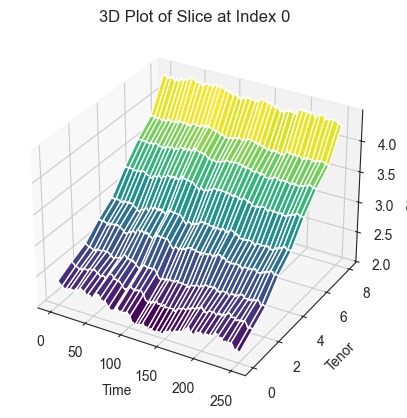

In [21]:
#from mpl_toolkits.mplot3d import Axes3D

# Choose a slice (e.g., slice along the 1000 axis at index 0)
slice_2d = quantile_rates_sims[:, :, 10]  # Shape (252, 9)

# Create the grid for plotting
x = np.arange(slice_2d.shape[0])
y = np.arange(slice_2d.shape[1])
X, Y = np.meshgrid(x, y)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, slice_2d.T, cmap='viridis')

# Labels and title
ax.set_title('3D Plot of Slice at Index 0')
ax.set_xlabel('Time')
ax.set_ylabel('Tenor')
ax.set_zlabel('Short rate')

plt.show()


In [22]:
#import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Create a random 3D array for demonstration (shape: 252 x 9 x 1000)
data = quantile_rates_sims

# Set up the grid for the surface plot
x = np.arange(data.shape[0])
y = np.arange(data.shape[1])
X, Y = np.meshgrid(x, y)

# Create a function to update the plot
def plot_slice(slice_index):
    # Create a new figure and 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Clear previous plot
    ax.clear()
    
    # Plot the selected slice
    slice_2d = data[:, :, slice_index]
    ax.plot_surface(X, Y, slice_2d.T, cmap='viridis')
    
    # Set axis labels
    ax.set_xlabel('Dimension 1 (252)')
    ax.set_ylabel('Dimension 2 (9)')
    ax.set_zlabel('Value')
    ax.set_title(f'Slice: {slice_index}')
    
    # Show the plot
    plt.show()

# Create an interactive slider
interact(plot_slice, slice_index=widgets.IntSlider(min=0, max=data.shape[2]-1, step=1, value=0))



interactive(children=(IntSlider(value=0, description='slice_index', max=999), Output()), _dom_classes=('widget…

<function __main__.plot_slice(slice_index)>

In [23]:
#price a swap for a short rate maturity 

def discount_factors(r_paths, dt, ax = 1):
    # Cumulative sum of the short rates over time
    return np.exp(-np.cumsum(r_paths * dt, axis=ax))

# Value the swap at maturity using the short-rate MC paths
def value_swap_at_maturity(r_paths, swap_maturity, fixed_rate, notional, dt):
    num_swap_payments = int(swap_maturity / dt)
    fixed_leg_value = np.sum(notional * fixed_rate * dt * np.ones((r_paths.shape[0], num_swap_payments)), axis=1)
    floating_leg_value = notional * (1 - discount_factors(r_paths, dt)[:, -1])  # Approximation for floating leg
    return floating_leg_value - fixed_leg_value


def value_swap(r_paths, swap_maturity, fixed_rate, notional, dt, ax = 1):
    num_swap_payments = int(swap_maturity / dt)
    #fixed_leg_value = np.sum(notional * fixed_rate * dt * np.ones(( num_swap_payments)))

    fixed_leg_value = 0
    discount_factors_at_payment = discount_factors(r_paths, dt,ax)
    
    for i in range(1, num_swap_payments + 1):
        # Payment made at time `i * dt`
        fixed_leg_value += notional * fixed_rate * dt * discount_factors_at_payment[:,i-1]
    
    fixed_leg_value += notional*discount_factors_at_payment[:,-1]

    fixed_leg_value = fixed_leg_value #* np.ones((r_paths.shape[0]))

    floating_leg_value = notional*(1 + r_paths[:, 0]*dt) * (discount_factors(r_paths, dt, ax)[:,0])  # Approximation for floating leg

    return floating_leg_value - fixed_leg_value


r_paths = quantile_rates_sims[:,0,:].T/100
swap_maturity = 1
fixed_rate = 0.03 #strike
notional = 1
dt = 1/252

# Compute swap values at maturity
swap_values_at_maturity = value_swap(r_paths, swap_maturity, fixed_rate, notional, dt)

# Compute swaption payoff (payer swaption) at maturity
swaption_payoffs = np.maximum(swap_values_at_maturity, 0)

# Discount payoffs back to present
discounted_payoff = np.mean(swaption_payoffs) * discount_factors(r_paths, dt)[:, -1]

# Compute the swaption price
swaption_price = np.mean(discounted_payoff)

print(f"The swaption price is (using quantile cali): {swaption_price:.5f}")

##########################################################
r_paths = rates_sims[:,0,:].T/100
swap_maturity = 1
fixed_rate = 0.03 #strike
notional = 1
dt = 1/252

# Compute swap values at maturity
swap_values_at_maturity = value_swap(r_paths, swap_maturity, fixed_rate, notional, dt)

# Compute swaption payoff (payer swaption) at maturity
swaption_payoffs = np.maximum(swap_values_at_maturity, 0)

# Discount payoffs back to present
discounted_payoff = np.mean(swaption_payoffs) * discount_factors(r_paths, dt)[:, -1]

# Compute the swaption price
swaption_price = np.mean(discounted_payoff)

print(f"The swaption price is (using MLE cali): {swaption_price:.5f}")

The swaption price is (using quantile cali): 0.00000
The swaption price is (using MLE cali): 0.00031


In [24]:
t_rate = np.array([0.03,0.04,0.04,0.035])
swap_maturity = 2
fixed_rate = 0.035
notional = 10000000
dt = 0.5

def value_swap(r_paths, swap_maturity, fixed_rate, notional, dt, ax = 1):
    num_swap_payments = int(swap_maturity / dt)
    #fixed_leg_value = np.sum(notional * fixed_rate * dt * np.ones(( num_swap_payments)))

    fixed_leg_value = 0
    discount_factors_at_payment = discount_factors(r_paths, dt,ax)
    
    for i in range(1, num_swap_payments + 1):
        # Payment made at time `i * dt`
        fixed_leg_value += notional * fixed_rate * dt * discount_factors_at_payment[i-1]
    
    fixed_leg_value += notional*discount_factors_at_payment[-1]

    floating_leg_value = notional*(1 + r_paths[0]*dt) * (discount_factors(r_paths, dt, 0)[0])  # Approximation for floating leg

    return floating_leg_value - fixed_leg_value


swap_price = value_swap(t_rate, swap_maturity, fixed_rate, notional, dt, ax = 0)

### Conclusions

This notebook shows the Vasicek short rate model, two methods of calibrating it and the pricing of an interest rate swaption.

The next noteboook will aim to explore the Hull-White model along with pricing more complex path dependent options.


